#**Project Overview:**

In this project I will analyze data from the Amazon Web Service.
More specifically, I will work with the Amazon Customer Reviews Data set. This data set has many categories. Each of the categories has its own data which contains columns such as marketplace, customer_id,product_title,product title, star_rating and more. 
I will print out some data frames so you will be able to see.

This project could be split into 4 parts as follows:
* Connecting to Amazon and getting the data.
* Preprocessing the data and doing some feature engineering
* fitting some classification models to the data sets
* Using mini-batches for Machine Learning

If you want to read more about the data set you can do so [here](https://s3.amazonaws.com/amazon-reviews-pds/readme.html)

Libraries and modules:

In [1]:
# More about boto3 can be read here https://boto3.amazonaws.com/v1/documentation/api/latest/index.html
%pip install boto3
!pip3 install flair

import boto3
import numpy as np
import pandas as pd
import gzip
import time
import matplotlib.pyplot as plt
import nltk
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('sentiment-fast') # building sentiment features
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     |████████████████████████████████| 131 kB 5.3 MB/s 
     |████████████████████████████████| 8.0 MB 42.5 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 138 kB 51.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 319 kB 5.3 MB/s 
     |████████████████████████████████| 2.9 MB 38.1 MB/s 
     |████████████████████████████████| 48 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 66.5 MB/s 

100%|██████████| 1241977025/1241977025 [00:53<00:00, 23317102.86B/s]

2021-10-04 11:04:35,334 copying /tmp/tmpsawe033s to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2021-10-04 11:04:39,665 removing temp file /tmp/tmpsawe033s
2021-10-04 11:04:39,840 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#**Chapter 1: Connecting to Amazon:**

In this chapter I will connect to the Amazon Cloud Storage using boto3. Using boto3, I will be able to connect to the amazon-reviews-pds bucket.
I'll create a connection to the bucket using the resource method of boto3. 
The Amazon_product_reviews variable will connect to the Amazon product reviews dataset.

In [2]:
 
# declaring a connection to AWSS3
s3conn = boto3.resource('s3',
                        aws_access_key_id ='HIDDEN_FOR_SAFETY'  ,
                        aws_secret_access_key = 'HIDDEN_FOR_SAFETY')
Amazon_product_reviews = s3conn.Bucket('amazon-reviews-pds')  # Connect to a database of Amazon product reviews
print(Amazon_product_reviews)

s3.Bucket(name='amazon-reviews-pds')


Let's do this:
* Focus only on data from the tab separated values (tsv) folder.
  * to do that, we will get all the keys of the files and keep them in a list, along with their size in bytes.
  * Then, we will go over the list of keys and keep only the keys which include tsv objects containing reviews from the United States
* Print out the elements of the said list.

To reiterate: I will loop over the keys_list and check for each item i in the list if it is both of the type tsv and is from the US. Each key that matches both conditions, will be saved into a filtered list. Finally, I will print the first 10 elements of the filtered keys.

In [3]:
keys_list = []
for my_bucket_object in Amazon_product_reviews.objects.all():
    keys_list.append([my_bucket_object.key,my_bucket_object.size])
filtered_list=[]
size=0
for i in range(len(keys_list)):
  if ('tsv' in (keys_list[i][0].lower()) and 'reviews_us' in (keys_list[i][0]).lower()):
    filtered_list.append([keys_list[i][0],keys_list[i][1]])
filtered_list[:]

[['tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz', 648641286],
 ['tsv/amazon_reviews_us_Automotive_v1_00.tsv.gz', 582145299],
 ['tsv/amazon_reviews_us_Baby_v1_00.tsv.gz', 357392893],
 ['tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz', 914070021],
 ['tsv/amazon_reviews_us_Books_v1_00.tsv.gz', 2740337188],
 ['tsv/amazon_reviews_us_Books_v1_01.tsv.gz', 2692708591],
 ['tsv/amazon_reviews_us_Books_v1_02.tsv.gz', 1329539135],
 ['tsv/amazon_reviews_us_Camera_v1_00.tsv.gz', 442653086],
 ['tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv.gz', 2689739299],
 ['tsv/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv.gz', 1294879074],
 ['tsv/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv.gz', 253570168],
 ['tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 18997559],
 ['tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', 506979922],
 ['tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz', 27442648],
 ['tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz', 698828243],
 ['tsv/amazon_review

We Can see multiple datasets with different categories and different sizes in bytes.

Since our resources are finite(Using google colab locally), I will want to do some analysis on a small dataset. let's find something which is relatively small. According to a quick calculation, Digital_Video_games seems to be about small enough. Let's download it. and do the following:
* read the entire data from the Digital_video_games category into a pandas dataframe and call it *df*
* print the number of datapoints and features.
* we can calculate the average size of each data point(row)



More Specifically: I will download the Digital_Video_Games data set, then go over it row by row, and trim it so it will be readable in the pandas data frame. Note that I have 2 replace methods for very close strings, for example "b'" and 'b"'. this will get rid of the appropriate substring that I do not want in the final data frame. The replace method will only replace if it finds the substring. Additionally, when creating the data frame, I found out the rows 44914,118318 and 133454 ended up not being equal to 15 after the trimming, hence the if statement (I will remove them from the final data frame).

In [4]:
keys_list=filtered_list[:]
print('file to read/stream: ', keys_list[13][0]) # downloading: Digital_Video_Games==13, aka row 13 in filtered_list above.
# changing the 13 to something else will download a different data set. from filtered_list above. see output in previous code block
fileToStream = keys_list[13][0]
s3conn.Bucket('amazon-reviews-pds').download_file(fileToStream, 'tmp.gz')
% ls /content/ -lah

with gzip.open('/content/tmp.gz', 'rb') as f_in:
    tmp = f_in.readlines() # Reading lines into a python object
### importing sys to calculate the size of each row in bytes.
import sys
totalsize=0
temp=tmp
final_data=[]
for row in range(len(temp)):
  curr_row=str(temp[row])
  trimmed_row=curr_row.strip().split("\\t")
  trimmed_row[0]=trimmed_row[0].replace("b'",'')
  trimmed_row[0]=trimmed_row[0].replace('b"','')
  trimmed_row[-1]=trimmed_row[-1].replace('\\n"','')
  trimmed_row[-1]=trimmed_row[-1].replace("\\n'",'')
  if (len(trimmed_row)==15):
    final_data.append(trimmed_row)
    #getting the size of each row for the average
    totalsize=totalsize+sys.getsizeof(trimmed_row)

print("========================================================================")
df=pd.DataFrame(data=final_data[1:],columns=final_data[0])
print("The Number of rows is ",len(df) , " and The number of Columns is ",len(df.columns))
avgsize=totalsize/len(df)
print("The Average size in bytes for each data point is ", round(avgsize,3))
print("========================================================================")


file to read/stream:  tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz
total 27M
drwxr-xr-x 1 root root 4.0K Oct  4 11:04 ./
drwxr-xr-x 1 root root 4.0K Oct  4 10:56 ../
drwxr-xr-x 4 root root 4.0K Sep 30 17:11 .config/
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data/
-rw-r--r-- 1 root root  27M Oct  4 11:04 tmp.gz
The Number of rows is  145428  and The number of Columns is  15
The Average size in bytes for each data point is  232.002


Let's see what the data frame looks like:

In [5]:
df.head(10)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31
5,US,22151364,R3CFKLIZ0I2KOB,B00IMIL498,621922192,Double Dragon: Neon [Online Game Code],Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31
6,US,38426028,R1LRYU1V0T3O38,B00S00IJH8,215163395,Sims 4,Digital_Video_Games,4,0,0,N,Y,i like the new skills like herbalism in this,"i like the new skills like herbalism in this, ...",2015-08-31
7,US,6057518,R44QKV6FE5CJ2,B004RMK4BC,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Super,2015-08-31
8,US,20715661,R2TX1KLPXXXNYS,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Easy & Fast,"Excellent, fast and secure!!!",2015-08-31
9,US,26540306,R1JEEW4C6R89BA,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Ok,2015-08-31


#**Chapter 2:Preprocessing & Feature Engineering:**

In this chapter I will turn the text data into features that will help with making predictions. I will also do some additional tinkering with the data and preprocess it so it could be fed into the classifier.

Let's create a function,call it nlp_proc, which will do the following:
* create a column called reviews_processed, which will be hold the review_body strings from the above dataframe *df*, all in lower-case. The next transformations will be done on the newly created reviews_processed column.
* use the word_tokenize method to split the strings into words and keep only the alpha numerical values.
* Remove redundancies
* Removing junk words
* rejoin the words back into a single string
* Remove datapoints which ended up being empty strings after this whole process.

In [6]:
def nlp_proc(dataF):
  #br is not a word, its a line break tag leftover from the trimming, 
  useless='br'
  dataF['reviews_processed']=dataF['review_body'].str.lower()
  engstop=stopwords.words('english')
  for i in range(len(dataF)):
    tokenized=word_tokenize(dataF['reviews_processed'][i])
    alphatokenized=[]
    for token in range(len(tokenized)):
      if (tokenized[token].isalpha()):
        alphatokenized.append(tokenized[token])
    lmtzr=WordNetLemmatizer()
    lemmatizedlist=[]
    for alpha in range(len(alphatokenized)):
      if (lmtzr.lemmatize(alphatokenized[alpha]) not in lemmatizedlist):
        lemmatizedlist.append(lmtzr.lemmatize(alphatokenized[alpha]))
    ## removing non informative words
### stopwords are in engstop
    informwords=[]
    for wrd in lemmatizedlist:
      if wrd not in engstop:
        informwords.append(wrd)
    ## remivoving line break tag leftover from the trimming so far.
    if useless in informwords: informwords.remove(useless)
    ### back to string
    temp_string=' '.join([str(item) for item in informwords])
    dataF['reviews_processed'][i]=temp_string
### turning empty strings into NA's recognized by pandas.
  ### I made sure the following code does exactly as asked in 7.
  ### reviews_processed will have empty string if the review_body had an empty string
  #### id's of empty strings in review_body
  #RKHI9WDB7S5WR
  #R2UJ6J6TUON90A
  dataF['reviews_processed'].replace('', np.nan, inplace=True)
  dataF.dropna(subset=['reviews_processed'], inplace=True)
  ### reindexing the data frame so we can iterate over it more easily.
  dataF.reset_index(drop=True, inplace=True)
  return dataF

This will take a while...

In [7]:
df=nlp_proc(df)

Let's see the fruits of our labor...

In [8]:
df.reviews_processed.head(20)

0     keep buying madden every year hoping get back ...
1                                               awesome
2     prepping end world one thing installed pc hail...
3                                               perfect
4                                               awesome
5                                               awesome
6     like new skill herbalism camping fun also buil...
7                                                 super
8                                 excellent fast secure
9                                                    ok
10    ha written many others quickly lost interest g...
11    probably best game learning aspect real estate...
12                                              awesome
13                                 cool lages alot time
14                      lame purchase almost never made
15                                                great
16                                              awesome
17    pretty good first brink consciousness game

Now that we "trimmed" the strings, we want to get some Sentiment analysis on them, to see if theyre either positive or negative, using the flair library.
Let's use a pretrained model to predict if the sentences are positive or negative I will use the pretrained model on the first 20 reviews in df.reviews_processed to see if we can get a feel / agree with the output.

In [9]:
classifier = TextClassifier.load('sentiment-fast')
for sentiment in range(20):
  ### processing...
  sentence = Sentence(df.reviews_processed[sentiment])
  classifier.predict(sentence)
  print("The Sentiment is : ", sentence.labels[0].value," ==== The Score is ", round(sentence.labels[0].score,5), " =====  The Review is  ",df.reviews_processed[sentiment])

2021-10-04 11:14:24,040 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt
The Sentiment is :  NEGATIVE  ==== The Score is  0.99993  =====  The Review is   keep buying madden every year hoping get back football version little better last saying game look great thing wrong animation way player always tripping gameplay still slowed bloated control used take two button giant pita done opponent snap ball play clock run turbo movement slow awkward liked guessing like chance anything training online crossing finger rest one recommend buy bundle come download hate trading gamestop
The Sentiment is :  POSITIVE  ==== The Score is  0.99709  =====  The Review is   awesome
The Sentiment is :  POSITIVE  ==== The Score is  0.85165  =====  The Review is   prepping end world one thing installed pc hail great yuri
The Sentiment is :  POSITIVE  ==== The Score is  0.99409  =====  The Review is   perfect
The Sentiment is :  POSITIVE  ==== The Score is  0.99709  =====  The Review is   awesome
T

I guess I can agree with the pretrained model's assessment. But when running the code, I noticed that it takes a pretty long time to run, let's see how long it takes for different numbers of data points...
Let's calculate the time it takes to compute the sentiments of 20,50,100,1000 and 10000 data points.

In [10]:
# creating a function that take a column of strings, and outputs it as a list of Sentence types.
### example/reminder for me:
### examplelist=Sentifier(df.reviews_processed[:10])
def Sentifier(dfcol):
  outlist=[]
  for i in range(len(dfcol)):
    outlist.append(Sentence(dfcol[i]))
  return outlist

#sentifying the datapoints first. this is to make the comparison more intuitive.
sentified_datapoints=Sentifier(df.reviews_processed[:10000])
### computing the time to compute the sentiments of 20,50,100,1000,10000 datapoints.
### sentify before everything.
import time
timelist=[]
sentimentlist=[20,50,100,1000,10000]
for datapoints in range(len(sentimentlist)):
  start_time=time.time()
  for sentiment in range(sentimentlist[datapoints]):
    sentence = sentified_datapoints[sentiment]
    classifier.predict(sentence)
  endtime=time.time()-start_time
  timelist.append(endtime)

print('SentimentList',sentimentlist,'      Time List: ',timelist)
average_time_approx=(timelist[0]/sentimentlist[0]+timelist[1]/sentimentlist[1]+timelist[2]/sentimentlist[2])/3
print('On average, the time per data point is about ' ,round(average_time_approx,4),' seconds. so it would take approximately',round(144991*round(average_time_approx,4),4),'seconds for the entire data set')

SentimentList [20, 50, 100, 1000, 10000]       Time List:  [0.04247331619262695, 0.13058924674987793, 0.21476101875305176, 2.4110569953918457, 23.877010583877563]
On average, the time per data point is about  0.0023  seconds. so it would take approximately 333.4793 seconds for the entire data set


according to my naive estimation it would take a pretty long time for the entire data set. I think I will need to do some mini-batching to speed things up.

Let's define a batch function that will create mini-batches from a given list.


In [11]:
## iterlist must be a list. ex=[]
### returns a list of lists, each sub-list has a batch.
def batch(iterlist,mini_batch_size):
  batch_list=[]
  if mini_batch_size >= len(iterlist):
    return iterlist
  if (len(iterlist) % mini_batch_size )!=0:
    batch_list.append(iterlist[:len(iterlist) % mini_batch_size])
    iterlist=iterlist[len(iterlist) % mini_batch_size:]
  while iterlist:
    batch_list.append(iterlist[:mini_batch_size])
    iterlist=iterlist[mini_batch_size:]
  return batch_list

Defining a get_sentiment function that will take a mini batch of the text data points and will output the predictions for the given minibatch

In [12]:
def get_sentiment(sent_list):
  sent_score=[]
  sent_value=[]
  for i in range(len(sent_list)):
    ## each location i in sent_list is holding many elements of different texts, the size of the mini batch size
    ### hence the predict is happening on a list and it predicts on a batch-sized prediction at once.
    classifier.predict(sent_list[i],verbose=True)
    ## saving the scores and values
    for j in range(len(sent_list[i])):
      sent_score.append(sent_list[i][j].labels[0].score)
      sent_value.append(sent_list[i][j].labels[0].value)
  return [sent_score,sent_value]

Now That I have the appropriate functions I will use ALL OF Them on 10000 data points. Then I will compare the time it took to process the sentiments with both batch and get_sentiment VS the naive approach.
Note that to make it as fair as possible, and because the .predict method does messy things. I will in both cases, preprocess the data points with my Sentifier function.

In [13]:
### preproccessing before timing, to make it as fair as possible.
total_batch=Sentifier(df.reviews_processed[:10000])

Now I will use both functions created above on the total_batch data and see how much time it takes to predict.


In [14]:
start_time=time.time()
batched_data=batch(total_batch,128)
sentiment_data=get_sentiment(batched_data)
endtime=time.time()-start_time
print("\n \n Using Both Batch() and get_sentiment() functions took ",endtime," Seconds")

Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 27.08it/s]


 
 Using Both Batch() and get_sentiment() functions took  12.280565977096558  Seconds


We can see that we basically shaved off some of  the runtime on 10000 datapoints by batching. By using batch() and get_sentiment() it took less time. By iterating, one-by-one it took more time. So i will use batching from now on.

Let's batch and get_sentiment over the whole data set, and add sentiment score and sentiment values to the original data frame.

In [15]:
complete_batch=Sentifier(df.reviews_processed)
complete_batched=batch(complete_batch,128)
sentiment_cols=get_sentiment(complete_batched)

Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]


In [16]:
###adding the appropriate columns
df['sent_score']=sentiment_cols[0]
df['sent_value']=sentiment_cols[1]
df.head(20)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,reviews_processed,sent_score,sent_value
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...,0.999926,NEGATIVE
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0.997095,POSITIVE
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one thing installed pc hail...,0.851653,POSITIVE
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0.994086,POSITIVE
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0.997095,POSITIVE
5,US,22151364,R3CFKLIZ0I2KOB,B00IMIL498,621922192,Double Dragon: Neon [Online Game Code],Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0.997095,POSITIVE
6,US,38426028,R1LRYU1V0T3O38,B00S00IJH8,215163395,Sims 4,Digital_Video_Games,4,0,0,N,Y,i like the new skills like herbalism in this,"i like the new skills like herbalism in this, ...",2015-08-31,like new skill herbalism camping fun also buil...,0.970928,POSITIVE
7,US,6057518,R44QKV6FE5CJ2,B004RMK4BC,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Super,2015-08-31,super,0.950873,POSITIVE
8,US,20715661,R2TX1KLPXXXNYS,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Easy & Fast,"Excellent, fast and secure!!!",2015-08-31,excellent fast secure,0.997535,POSITIVE
9,US,26540306,R1JEEW4C6R89BA,B00K59HKIQ,384246568,Playstation Network Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Ok,2015-08-31,ok,0.563957,POSITIVE


I want to do some Logistic Regression using this data. I will set the star ratings of 1,2 to be zero and star ratings of 4,5 to be one. Neutral ratings of 3 will be ignored. I will remove bad values such as nans and infinities. Additionally, I will make sure that every feature has the right ".astype()" value. Let's define the function _modifix_ to do that and apply it to our data frame df.

In [17]:
def modifix(pandata):
  binstar=[]
  bin_purch=[]
  
  pandata['marketplace']=pandata['marketplace'].astype(str)
  pandata['customer_id']=pandata['customer_id'].astype(str)
  pandata['review_id']=pandata['review_id'].astype(str)
  pandata['product_id']=pandata['product_id'].astype(str)
  pandata['product_parent']=pandata['product_parent'].astype(str)
  pandata['product_title']=pandata['product_title'].astype(str)
  pandata['product_category']=pandata['product_category'].astype(str)
  pandata['star_rating']=pandata['star_rating'].astype(int)
  pandata['helpful_votes']=pandata['helpful_votes'].astype(int)
  pandata['total_votes']=pandata['total_votes'].astype(int)
  pandata['vine']=pandata['vine'].astype(str)
  pandata['verified_purchase']=pandata['verified_purchase'].astype(str)
  
  for purchase in range(len(pandata)):
    if pandata.verified_purchase[purchase]=='Y':
      bin_purch.append(1)
    else:
      bin_purch.append(0)
  ### 1 verified, 0 not verified purchase.
  pandata['binverified']=bin_purch
  pandata['binverified']=pandata['binverified'].astype(int)
  
  pandata['review_headline']=pandata['review_headline'].astype(str)
  pandata['review_body']=pandata['review_body'].astype(str)
  pandata['review_date']=pandata['review_date'].astype(str)
  pandata['reviews_processed']=pandata['reviews_processed'].astype(str)
  pandata['sent_score']=pandata['sent_score'].astype(float)
  pandata['sent_value']=pandata['sent_value'].astype(str)
  # binary sentiments 0 for negative 1 for positive.
  binsent=[]
  for val in range(len(pandata)):
    if pandata.sent_value[val]=="NEGATIVE":
      binsent.append(0)
    else:
      binsent.append(1)
  pandata['binsent']=binsent

  ### LOW STAR 0 HIGH STAR 1
  for rating in range(len(pandata)):
    if pandata.star_rating[rating]==1 or pandata.star_rating[rating]==2:
      binstar.append(0)
    elif pandata.star_rating[rating]==4 or pandata.star_rating[rating]==5:
      binstar.append(1)
    else:
      binstar.append(np.nan)

  pandata['binstar']=binstar

  ##pandata['helpful_percent']=pandata['helpful_votes']/pandata['total_votes']

  ### getting rid of np.inf, -np.inf and np.nan.
  pandata.replace([np.inf, -np.inf], np.nan)
  pandata.dropna(inplace=True)
  #can only do that after we drop the np.nans
  pandata['binstar']=pandata['binstar'].astype(int)
  pandata.reset_index(drop=True, inplace=True)
  return pandata



df=modifix(df)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,reviews_processed,sent_score,sent_value,binverified,binsent,binstar
0,US,21269168,RSH1OZ87OYK92,B013PURRZW,603406193,Madden NFL 16 - Xbox One Digital Code,Digital_Video_Games,2,2,3,N,N,A slight improvement from last year.,I keep buying madden every year hoping they ge...,2015-08-31,keep buying madden every year hoping get back ...,0.999926,NEGATIVE,0,0,0
1,US,133437,R1WFOQ3N9BO65I,B00F4CEHNK,341969535,Xbox Live Gift Card,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome,2015-08-31,awesome,0.997095,POSITIVE,1,1,1
2,US,45765011,R3YOOS71KM5M9,B00DNHLFQA,951665344,Command & Conquer The Ultimate Collection [Ins...,Digital_Video_Games,5,0,0,N,Y,Hail to the great Yuri!,If you are prepping for the end of the world t...,2015-08-31,prepping end world one thing installed pc hail...,0.851653,POSITIVE,1,1,1
3,US,113118,R3R14UATT3OUFU,B004RMK5QG,395682204,Playstation Plus Subscription,Digital_Video_Games,5,0,0,N,Y,Five Stars,Perfect,2015-08-31,perfect,0.994086,POSITIVE,1,1,1
4,US,22151364,RV2W9SGDNQA2C,B00G9BNLQE,640460561,Saints Row IV - Enter The Dominatrix [Online G...,Digital_Video_Games,5,0,0,N,Y,Five Stars,Awesome!,2015-08-31,awesome,0.997095,POSITIVE,1,1,1


Since im about to use logistic regression:
Reminder: one of the assumption of logistic regression is that the feature columns are independent of eachother. Therefore, multicollinearity is obviously violating the assumption. 
I could get a model with high accuracy, but it would not be reliable on real world data. Notice the correlation between the two columns helpful_votes and total_votes.


In [18]:
print("The Correlation between helpful_votes and total votes is ",round((df['helpful_votes'].astype(int)).corr((df['total_votes']).astype(int)),5))


The Correlation between helpful_votes and total votes is  0.96537


I think that the best way to get rid of this problem is to only use the helpful votes.

Since Idk what's going on with the mapper, I'll let the mapper do it's thing on everything and I will hard-code the part for reviews_processed myself.
Additionally, I will have the column names appropriate for the new columns for each word in 'words'. Additionally, I decided to use instead of sent_value, the binsent column I created, so we dont have to worry about "NEGATIVE" and "POSITIVE" strings and we have 1s and 0s. I also decided to use binverified column too. I think it makes sense to take into account if a review has been made by an actual customer.

In [19]:
#### since idk what'ss going on with the mapper, i'll let the mapper do it's thing on everything else, and i will Hard-code the reviews_processed part myself
vectorizer=TfidfVectorizer(max_features=100)
tfidf=vectorizer.fit_transform(df['reviews_processed'])
## okay now I have it in the same format as the shit i need for the final_array
tfidf=tfidf.toarray()
### The top 100 words will be stored in 'words'
words=vectorizer.get_feature_names()
#### now tfidf is a nparray with .shape of (133373, 100) ill concatenate and im done.

mapper = DataFrameMapper([
     ('helpful_votes', None),
     ('sent_score', None),
     ('binsent',None),
     ('binverified',None),

 ], df_out=False)
mapper_fit = mapper.fit(df)
final_df = mapper.transform(df) # a numpy array 

final_df=np.concatenate((final_df, tfidf), axis=1)
final_df.shape

(133373, 104)

Now we can fit a Logistic Regression Model.

#**Chapter 3: Modeling and Predictions**

I want to predict the star rating binstar using the other features. I will create a train/test split of the final_df dataframe and have the target variable be binstar. But first, I would like to normalize the helpful votes, to make the logistic regression work better.

###Naive Logistic Regression


In [20]:
#sum(final_Df[:,0]<0)
## since there are no negative helpful votes all we have to do is just divide by the max to scale 
#the idea is ---> final_df[:,0]=final_df[:,0] / final_df[:0].max()
max_helpful_votes=final_df[:,0].max()
for i in range(len(final_df[:,0])):
  final_df[i,0]=final_df[i,0]/max_helpful_votes
y=np.array(df['binstar'])
x_train_q3,x_test_q3,y_train_q3,y_test_q3=train_test_split(final_df,y,test_size=0.2,random_state=42)

Now let's fit a Logistic Regression Model to the training set and get the accuracies and errors.

In [21]:
logistic_model=LogisticRegression()
logistic_model.fit(x_train_q3,y_train_q3)
logistic_model_preds=logistic_model.predict(x_test_q3)
training_score=logistic_model.score(x_train_q3,y_train_q3)
testing_score=logistic_model.score(x_test_q3,y_test_q3)
print("The train model accuracy is: ",training_score,"    The test model accuracy is:  ", testing_score)
print("The train model error is: ",1-training_score,"    The test model error is:  ", 1-testing_score)

The train model accuracy is:  0.878263884983786     The test model accuracy is:   0.8797000937207122
The train model error is:  0.12173611501621395     The test model error is:   0.12029990627928777


### Can I get better accuracy than this?

Let's create a voting system of 3 different ML algorithms to try and increase the accuracy.

The voting system will consist of the following algorithms:


* Logistic Regression.
I will choose this algorithm as one of my "voters" because first of all, it was pretty much designed for classification especially [0,1]


* On-Line SVM with Stochastic Gradient Descent
this algorithm is simple and very efficient. Additionally it appears to be extremely useful with the data set has many samples. I'll use the hinge loss for SGDClassifier to get an online SVM classifier

* Naive Bayes:
I really like this algorithm, even though this is a weak learner. The good news about this classifier is that it is super fast O(nk), n=number of features, k=number of label classes



I will use sklearn to fit the algorithms. And then I will do some coding for the voting mechanism. I will then calculate the accuracy. 
The already-split data is in x_train_q3,x_test_q3,y_train_q3,y_test_q3

In [22]:
## importing naive bayes
from sklearn.naive_bayes import GaussianNB

Creating a voting model that will classify each sample by the majority vote. The function will return the predictions. as a list the length of input of test data.

In [23]:
def voted_predictions(x_train,x_test,y_train,y_test):
  ### declaring three vote models.
  final_preds=[]
  #logistic regression
  lr=LogisticRegression()
  lr.fit(x_train,y_train)
  lr_prediction=lr.predict(x_test)
  #on line support vector machine
  on_line_svm=SGDClassifier(loss='hinge')
  on_line_svm.fit(x_train,y_train)
  on_line_svm_prediction=on_line_svm.predict(x_test)
  #naive bayes
  gauss=GaussianNB()
  gauss.fit(x_train_q3,y_train_q3)
  gauss_prediction=gauss.predict(x_test)

  voters_predictions=gauss_prediction+on_line_svm_prediction+lr_prediction
  for i in range(len(voters_predictions)):
    if voters_predictions[i]>1:
      final_preds.append(1)
    else:
      final_preds.append(0)

  return final_preds


Now, Since i can't use the .score method, i will have to create a function that will calculate the accuracy. 
As we Know, accuracy is calculated as follows: 


Accuracy=(TP+TN)/(TP+TN+FP+FN)


In [24]:
def voted_accuracy(real_list,predicted_list):
  tp=0
  tn=0
  fp=0
  fn=0
  for i in range(len(real_list)):
    if predicted_list[i]==1 & real_list[i]==1:
      tp=tp+1
    elif predicted_list[i]==0 & real_list[i]==0:
      tn=tn+1  
    elif predicted_list[i]==1 & real_list[i]==0:
      fp=fp+1
    else:
      fn=fn+1
    accuracy=(tp+tn)/(tp+tn+fp+fn)
  return accuracy


My algorithm will consist of both voted_accuracy and the voted_predictions functions. Let's time them and see what we get:

In [25]:
start_time_vote=time.time()
vote_winners=voted_predictions(x_train_q3,x_test_q3,y_train_q3,y_test_q3)
accuracy_is=voted_accuracy(y_test_q3,vote_winners)
endtime_vote=time.time()-start_time_vote

print("The accuracy for my algorithm is: ",accuracy_is," and the runtime was: ",round(endtime_vote,4)," Seconds.")

The accuracy for my algorithm is:  0.9355951265229616  and the runtime was:  4.8448  Seconds.


Okay so I can get better accuracy if I were to use a voting system.


###Back To logistic Regression:

Let's see the change in error with increase in sample size. Note: Im only using logistic regression from now untill the end of this chapter to do some analysis.

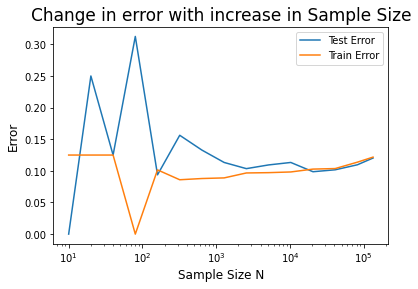

In [26]:
test_errors=[]
train_errors=[]
test_acc=[]
train_acc=[]
length_list = [ 10 * 2**j for j in range(0,14+1) ]
if length_list[-1]>len(final_df):
  length_list[-1]=len(final_df)

comparison_model=LogisticRegression(random_state=42)

for n in range(len(length_list)):
  comparison_model=LogisticRegression()
  temp_feature_size=final_df[:length_list[n],:]
  temp_y=y[:length_list[n]]
  x_train,x_test,y_train,y_test=train_test_split(temp_feature_size,temp_y,test_size=0.2,random_state=42)
  comparison_model.fit(x_train,y_train)
  
  train_errors.append(1-comparison_model.score(x_train,y_train))
  test_errors.append(1-comparison_model.score(x_test,y_test))
  train_acc.append(comparison_model.score(x_train,y_train))
  test_acc.append(comparison_model.score(x_test,y_test))

plt.title("Change in error with increase in Sample Size",size=17)
plt.xlabel("Sample Size N",size=12)
plt.ylabel("Error",size=12)
plt.plot(length_list,test_errors)
plt.plot(length_list,train_errors)
plt.xscale('log')
plt.legend(['Test Error','Train Error'])

We can see an overall improvement in test error when increasing the sample size. We can also see that both the test and train error converge to around the same number about 0.12

Let's see the Change in Accuracy with Increase in Sample Size:

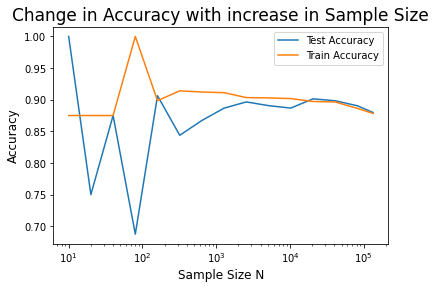

In [27]:
plt.title("Change in Accuracy with increase in Sample Size",size=17)
plt.xlabel("Sample Size N",size=12)
plt.ylabel("Accuracy",size=12)
plt.plot(length_list,test_acc)
plt.plot(length_list,train_acc)
plt.xscale('log')
plt.legend(['Test Accuracy','Train Accuracy'])

So far, We've only used a single dataset from the Amazon Reviews Dataset.
What I would like to do is to use more categories from the Amazon Reviews Dataset.
Specifically, I would like to see what would happen if I would create a combined model:
Firstly, I will run 10 different Logistic Regression models on 10 different Amazon Reviews categories, and examine the accuracies.
The combined model will be created by averaging these 10 Logisic Regression Models (both coeffs and intercepts). What would have higher accuracy? The combiend model which was created by averaging 10 different data categories? or the model that was fitted on its appropriate category alone by itself?
Ill create two tables which will be used to compare the two ideas.

let's pick some random categories from the filtered_list.

In [28]:
filtered_list[16],filtered_list[34],filtered_list[11],filtered_list[28],filtered_list[26],filtered_list[13],filtered_list[25],filtered_list[37],filtered_list[43],filtered_list[15]

(['tsv/amazon_reviews_us_Gift_Card_v1_00.tsv.gz', 12134676],
 ['tsv/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz', 17634794],
 ['tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 18997559],
 ['tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz', 22870508],
 ['tsv/amazon_reviews_us_Major_Appliances_v1_00.tsv.gz', 24359816],
 ['tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz', 27442648],
 ['tsv/amazon_reviews_us_Luggage_v1_00.tsv.gz', 60320191],
 ['tsv/amazon_reviews_us_Software_v1_00.tsv.gz', 94010685],
 ['tsv/amazon_reviews_us_Video_v1_00.tsv.gz', 138929896],
 ['tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz', 148982796])

Let's try this with 10 categories:
Gift_Card, Personal_Care_Appliances,Digital_Software	,Mobile_Electronics,Major_Appliances,Digital_Video_Games,Luggage,Software,Video,Furniture.

Now I will do ALL of the preprocessing and feature engineering that I have done above on every category. I will try to make it clearer using functions, but this is gonna be kind of ugly.

In [29]:
## creating a function that will download the data, and turn it into a pandas data frame.
### input will be the category index which is the category's filtered_list row index
### second input is the number of rows for the OUTPUT DF! 
def download_and_pandatize(category_index,num_rows):
  num_rows=num_rows+1
  fileToStream = keys_list[category_index][0]
  s3conn.Bucket('amazon-reviews-pds').download_file(fileToStream, 'tmp.gz')
  % ls /content/ -lah
  with gzip.open('/content/tmp.gz', 'rb') as f_in:
    ### downloading 10001 rows because the first row is the column names!
      downloaded_data = [next(f_in) for x in range(num_rows)] # Reading lines into a python object
  data_set=[]
  for row in range(len(downloaded_data)):
    curr_row=str(downloaded_data[row])
    trimmed_row=curr_row.strip().split("\\t")
    trimmed_row[0]=trimmed_row[0].replace("b'",'')
    trimmed_row[0]=trimmed_row[0].replace('b"','')
    trimmed_row[-1]=trimmed_row[-1].replace('\\n"','')
    trimmed_row[-1]=trimmed_row[-1].replace("\\n'",'')
    ### the if gets rid of outlier rows with problematic syntax.
    if (len(trimmed_row)==15):
      data_set.append(trimmed_row)
  output_data=pd.DataFrame(data=data_set[1:],columns=data_set[0])
  return output_data


#### adding the sent_score and sent_value columns to the data frame, by function.
### input should be the whole data frame.
def sentiment_score_value_cols(df):
  sentiments=get_sentiment(batch(Sentifier(df.reviews_processed),128))
  df['sent_score']=sentiments[0]
  df['sent_value']=sentiments[1]
  return df


def df_to_nparray(df):
  vectorizer=TfidfVectorizer(max_features=100)
  tfidf=vectorizer.fit_transform(df['reviews_processed']) 
  tfidf=tfidf.toarray()
   
  mapper = DataFrameMapper([
      ('helpful_votes', None),
      ('sent_score', None),
      ('binsent',None),
      ('binverified',None),

  ], df_out=False)
  mapper_fit = mapper.fit(df)
  final_df = mapper.transform(df) # a numpy array 
  ### Reminder: first 4 cols will be from the DataFrameMapper and the last 100 will be from the tfidfe
  final_df=np.concatenate((final_df, tfidf), axis=1)
  return final_df 





  ### X_vals and Y_vals must both be np arrays.
def learn_LogisticRegression(X_vals,Y_vals):
  #### accuracies[0]= train accuracy,  accuracies[1] = test accuracy
  accuracies=[]

  x_train,x_test,y_train,y_test=train_test_split(X_vals,Y_vals,test_size=0.2)
  logistic_model=LogisticRegression()
  logistic_model.fit(x_train,y_train)
  training_score=logistic_model.score(x_train,y_train)
  testing_score=logistic_model.score(x_test,y_test)
  accuracies.append(training_score)
  accuracies.append(testing_score)
  return logistic_model,accuracies


### normalizing the helpful votes function
### gets an np array according to how I pre-made it and normalizes to appropriate column.
def normalize_helpful_votes(final_df):
  max_helpful_votes=final_df[:,0].max()
  for i in range(len(final_df[:,0])):
    final_df[i,0]=final_df[i,0]/max_helpful_votes
  return final_df

In [30]:
### each of these is a pandas dataframe with 10000 rows. 
Gift_Card=download_and_pandatize(16,10000)
Personal_Care_Appliances=download_and_pandatize(34,10000)
Digital_Software=download_and_pandatize(11,10000)
Mobile_Electronics=download_and_pandatize(28,10000)
Major_Appliances=download_and_pandatize(26,10000)
Luggage=download_and_pandatize(25,10000)
Software=download_and_pandatize(37,10000)
Video=download_and_pandatize(43,10000)
Furniture=download_and_pandatize(15,10000)
Digital_Video_Games=download_and_pandatize(13,10000)

total 12M
drwxr-xr-x 1 root root 4.0K Oct  4 11:22 ./
drwxr-xr-x 1 root root 4.0K Oct  4 10:56 ../
drwxr-xr-x 4 root root 4.0K Sep 30 17:11 .config/
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data/
-rw-r--r-- 1 root root  12M Oct  4 11:22 tmp.gz
total 17M
drwxr-xr-x 1 root root 4.0K Oct  4 11:22 ./
drwxr-xr-x 1 root root 4.0K Oct  4 10:56 ../
drwxr-xr-x 4 root root 4.0K Sep 30 17:11 .config/
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data/
-rw-r--r-- 1 root root  17M Oct  4 11:22 tmp.gz
total 19M
drwxr-xr-x 1 root root 4.0K Oct  4 11:22 ./
drwxr-xr-x 1 root root 4.0K Oct  4 10:56 ../
drwxr-xr-x 4 root root 4.0K Sep 30 17:11 .config/
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data/
-rw-r--r-- 1 root root  19M Oct  4 11:22 tmp.gz
total 22M
drwxr-xr-x 1 root root 4.0K Oct  4 11:22 ./
drwxr-xr-x 1 root root 4.0K Oct  4 10:56 ../
drwxr-xr-x 4 root root 4.0K Sep 30 17:11 .config/
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data/
-rw-r--r-- 1 root root  22M Oct  4 11:22 tmp

In [31]:
### processing...
Gift_Card=nlp_proc(Gift_Card)
Personal_Care_Appliances=nlp_proc(Personal_Care_Appliances)
Digital_Software=nlp_proc(Digital_Software)
Mobile_Electronics=nlp_proc(Mobile_Electronics)
Major_Appliances=nlp_proc(Major_Appliances)
Luggage=nlp_proc(Luggage)
Software=nlp_proc(Software)
Video=nlp_proc(Video)
Furniture=nlp_proc(Furniture)
Digital_Video_Games=nlp_proc(Digital_Video_Games)

In [32]:
## adding sentiments score and value columns...
Gift_Card=sentiment_score_value_cols(Gift_Card)
Personal_Care_Appliances=sentiment_score_value_cols(Personal_Care_Appliances)
Digital_Software=sentiment_score_value_cols(Digital_Software)
Mobile_Electronics=sentiment_score_value_cols(Mobile_Electronics)
Major_Appliances=sentiment_score_value_cols(Major_Appliances)
Luggage=sentiment_score_value_cols(Luggage)
Software=sentiment_score_value_cols(Software)
Video=sentiment_score_value_cols(Video)
Furniture=sentiment_score_value_cols(Furniture)
Digital_Video_Games=sentiment_score_value_cols(Digital_Video_Games)

Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 25.04it/s]


In [33]:
### preparing the data frames for the DataFrameMapper and the tfidf vectorizer 
Gift_Card=modifix(Gift_Card)
Personal_Care_Appliances=modifix(Personal_Care_Appliances)
Digital_Software=modifix(Digital_Software)
Mobile_Electronics=modifix(Mobile_Electronics)
Major_Appliances=modifix(Major_Appliances)
Luggage=modifix(Luggage)
Software=modifix(Software)
Video=modifix(Video)
Furniture=modifix(Furniture)
Digital_Video_Games=modifix(Digital_Video_Games)

In [34]:
### saving all the Y values
Y_Gift_Card=Gift_Card['binstar']
Y_Personal_Care_Appliances=Personal_Care_Appliances['binstar']
Y_Digital_Software=Digital_Software['binstar']
Y_Mobile_Electronics=Mobile_Electronics['binstar']
Y_Major_Appliances=Major_Appliances['binstar']
Y_Luggage=Luggage['binstar']
Y_Software=Software['binstar']
Y_Video=Video['binstar']
Y_Furniture=Furniture['binstar']
Y_Digital_Video_Games=Digital_Video_Games['binstar']

Creating a function that will get a data frame as input, compute the tfidf vectorizer, then Use the dataframe mapper then output an np.array ready for regression.

In [35]:

### turning every data frame into an nparray ready for the LogisticRegression.
Gift_Card=df_to_nparray(Gift_Card)
Personal_Care_Appliances=df_to_nparray(Personal_Care_Appliances)
Digital_Software=df_to_nparray(Digital_Software)
Mobile_Electronics=df_to_nparray(Mobile_Electronics)
Major_Appliances=df_to_nparray(Major_Appliances)
Luggage=df_to_nparray(Luggage)
Software=df_to_nparray(Software)
Video=df_to_nparray(Video)
Furniture=df_to_nparray(Furniture)
Digital_Video_Games=df_to_nparray(Digital_Video_Games)

In [36]:
### applying normalization to the  helpful votes column.

Gift_Card=normalize_helpful_votes(Gift_Card)
Personal_Care_Appliances=normalize_helpful_votes(Personal_Care_Appliances)
Digital_Software=normalize_helpful_votes(Digital_Software)
Mobile_Electronics=normalize_helpful_votes(Mobile_Electronics)
Major_Appliances=normalize_helpful_votes(Major_Appliances)
Luggage=normalize_helpful_votes(Luggage)
Software=normalize_helpful_votes(Software)
Video=normalize_helpful_votes(Video)
Furniture=normalize_helpful_votes(Furniture)
Digital_Video_Games=normalize_helpful_votes(Digital_Video_Games)

Time For the Logistic Regression!
learn_LogisticRegression is  a Function that takes the nparray and the y value and trains a logistic regression model, then returns it. This will help me save a few lines of code.

In [37]:
Gift_Card_Model,Gift_Card_Acc=learn_LogisticRegression(Gift_Card,Y_Gift_Card)
Personal_Care_Appliances_Model,Personal_Care_Appliances_Acc=learn_LogisticRegression(Personal_Care_Appliances,Y_Personal_Care_Appliances)
Digital_Software_Model,Digital_Software_Acc=learn_LogisticRegression(Digital_Software,Y_Digital_Software)
Mobile_Electronics_Model,Mobile_Electronics_Acc=learn_LogisticRegression(Mobile_Electronics,Y_Mobile_Electronics)
Major_Appliances_Model,Major_Appliances_Acc=learn_LogisticRegression(Major_Appliances,Y_Major_Appliances)
Luggage_Model,Luggage_Acc=learn_LogisticRegression(Luggage,Y_Luggage)
Software_Model,Software_Acc=learn_LogisticRegression(Software,Y_Software)
Video_Model,Video_Acc=learn_LogisticRegression(Video,Y_Video)
Furniture_Model,Furniture_Acc=learn_LogisticRegression(Furniture,Y_Furniture)
Digital_Video_Games_Model,Digital_Video_Games_Acc=learn_LogisticRegression(Digital_Video_Games,Y_Digital_Video_Games)

In [38]:
Accuracies_Table = pd.DataFrame(
    {'Gift_Card': Gift_Card_Acc,
     'Personal_Care_Appliances': Personal_Care_Appliances_Acc,
     'Digital_Software': Digital_Software_Acc,
     'Mobile_Electronics': Mobile_Electronics_Acc,
     'Major_Appliances':Major_Appliances_Acc,
     'Luggage':Luggage_Acc,
     'Software':Software_Acc,
     'Video':Video_Acc,
     'Furniture':Furniture_Acc,
     'Digital_Video_Games':Digital_Video_Games_Acc,
    },
    index=['Train_Accuracies', 'Test_Accuracies'])


Averaging the fitted models coefficients and intercepts from all categories to create a combined model.

In [39]:
total_coeffs=Gift_Card_Model.coef_+Personal_Care_Appliances_Model.coef_+Digital_Software_Model.coef_+Mobile_Electronics_Model.coef_+Major_Appliances_Model.coef_+Luggage_Model.coef_+Software_Model.coef_+Video_Model.coef_+Furniture_Model.coef_+Digital_Video_Games_Model.coef_
total_coeffs=total_coeffs/10
total_intercepts=Gift_Card_Model.intercept_+Personal_Care_Appliances_Model.intercept_+Digital_Software_Model.intercept_+Mobile_Electronics_Model.intercept_+Major_Appliances_Model.intercept_+Luggage_Model.intercept_+Software_Model.intercept_+Video_Model.intercept_+Furniture_Model.intercept_+Digital_Video_Games_Model.intercept_
total_intercepts_avg=total_intercepts/10
combined_model=LogisticRegression()
combined_model.coef_=total_coeffs
combined_model.intercept_=total_intercepts_avg
combined_model.classes_=np.array([0,1])

Testing the combined model on each category.

In [40]:
x_train,x_test,y_train,y_test=train_test_split(Gift_Card,Y_Gift_Card,test_size=0.2)
Gift_Card_scores=[]
Gift_Card_scores.append(combined_model.score(x_train,y_train))
Gift_Card_scores.append(combined_model.score(x_test,y_test))




x_train,x_test,y_train,y_test=train_test_split(Personal_Care_Appliances,Y_Personal_Care_Appliances,test_size=0.2)
Personal_Care_Appliances_scores=[]
Personal_Care_Appliances_scores.append(combined_model.score(x_train,y_train))
Personal_Care_Appliances_scores.append(combined_model.score(x_test,y_test))



x_train,x_test,y_train,y_test=train_test_split(Digital_Software,Y_Digital_Software,test_size=0.2)
Digital_Software_scores=[]
Digital_Software_scores.append(combined_model.score(x_train,y_train))
Digital_Software_scores.append(combined_model.score(x_test,y_test))




x_train,x_test,y_train,y_test=train_test_split(Mobile_Electronics,Y_Mobile_Electronics,test_size=0.2)
Mobile_Electronics_scores=[]
Mobile_Electronics_scores.append(combined_model.score(x_train,y_train))
Mobile_Electronics_scores.append(combined_model.score(x_test,y_test))



x_train,x_test,y_train,y_test=train_test_split(Major_Appliances,Y_Major_Appliances,test_size=0.2)
Major_Appliances_scores=[]
Major_Appliances_scores.append(combined_model.score(x_train,y_train))
Major_Appliances_scores.append(combined_model.score(x_test,y_test))



x_train,x_test,y_train,y_test=train_test_split(Luggage,Y_Luggage,test_size=0.2)
Luggage_scores=[]
Luggage_scores.append(combined_model.score(x_train,y_train))
Luggage_scores.append(combined_model.score(x_test,y_test))




x_train,x_test,y_train,y_test=train_test_split(Software,Y_Software,test_size=0.2)
Software_scores=[]
Software_scores.append(combined_model.score(x_train,y_train))
Software_scores.append(combined_model.score(x_test,y_test))




x_train,x_test,y_train,y_test=train_test_split(Video,Y_Video,test_size=0.2)
Video_scores=[]
Video_scores.append(combined_model.score(x_train,y_train))
Video_scores.append(combined_model.score(x_test,y_test))



x_train,x_test,y_train,y_test=train_test_split(Furniture,Y_Furniture,test_size=0.2)
Furniture_scores=[]
Furniture_scores.append(combined_model.score(x_train,y_train))
Furniture_scores.append(combined_model.score(x_test,y_test))





x_train,x_test,y_train,y_test=train_test_split(Digital_Video_Games,Y_Digital_Video_Games,test_size=0.2)
Digital_Video_Games_scores=[]
Digital_Video_Games_scores.append(combined_model.score(x_train,y_train))
Digital_Video_Games_scores.append(combined_model.score(x_test,y_test))

In [41]:
combined_model_Table = pd.DataFrame(
    {'Gift_Card': Gift_Card_scores,
     'Personal_Care_Appliances': Personal_Care_Appliances_scores,
     'Digital_Software': Digital_Software_scores,
     'Mobile_Electronics': Mobile_Electronics_scores,
     'Major_Appliances':Major_Appliances_scores,
     'Luggage':Luggage_scores,
     'Software':Software_scores,
     'Video':Video_scores,
     'Furniture':Furniture_scores,
     'Digital_Video_Games':Digital_Video_Games_scores,
    },
    index=['Train_Accuracies', 'Test_Accuracies'])


Accuracies when running a logistic regression model on each category separately:

In [42]:
Accuracies_Table

,Gift_Card,Personal_Care_Appliances,Digital_Software,Mobile_Electronics,Major_Appliances,Luggage,Software,Video,Furniture,Digital_Video_Games
Train_Accuracies,0.96573,0.920595,0.869333,0.890480,0.912594,0.945058,0.870893,0.943621,0.927148,0.896964
Test_Accuracies,0.96136,0.914882,0.870756,0.885979,0.910849,0.933226,0.855969,0.942308,0.908191,0.904352


Accuracies for the Combined Model, for each category.

In [43]:
combined_model_Table

,Gift_Card,Personal_Care_Appliances,Digital_Software,Mobile_Electronics,Major_Appliances,Luggage,Software,Video,Furniture,Digital_Video_Games
Train_Accuracies,0.955553,0.896893,0.745377,0.835243,0.824382,0.913816,0.799836,0.926787,0.892646,0.828318
Test_Accuracies,0.954147,0.907388,0.722344,0.826514,0.824382,0.915455,0.803943,0.926282,0.904343,0.836110


The accuracies are worse for all categories, I think its because the words we get from the tfidfvectorizer are not the same for all sub models. I also think that there's probably a different "review - culture" for each type of data set. 
It is important to note that the accuracies are not that worse than each category fitted to itself. This might be useful if we want just one final model to make predictions for all the different data sets. if we dont mind having 10 different models, then I think it would be better to use each one of the ten for its specific category.

#**Chapter4: Streaming & fitting using batches:**

So far I was able to create a prediction model using a small subset of the data,that is because there's a limit on google colab's resources(memory). I can get around this problem by using the stochastic gradient descent classifier to train a model on a subset (batch) per epoch.

I will now use the same train/test split from chapter 3 to try out the partial fit method of the stochastic gradient descent classifier. I will also compute the AVG of the log loss, with the equations provided below, which were taken from wikipedia. For every partial fit I will calculate the avg. of the log loss for the given epoch, and save it into a list. Finally, I will plot the avg. log loss as a function of the epochs.
The equations for the loss are as follows:

 \begin{aligned}J(\mathbf {w} )\ =\ {\frac {1}{N}}\sum _{n=1}^{N}H(p_{n},q_{n})\ =\ -{\frac {1}{N}}\sum _{n=1}^{N}\ {\bigg [}y_{n}\log {\hat {y}}_{n}+(1-y_{n})\log(1-{\hat {y}}_{n}){\bigg ]}\,,\end{aligned}

Where y hat of n is defined as:

\begin{aligned} {\hat {y}}_{n}\equiv g(\mathbf {w} \cdot \mathbf {x} _{n})=1/(1+e^{-\mathbf {w} \cdot \mathbf {x} _{n}})\end{aligned}

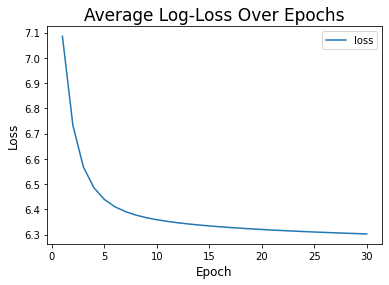

In [44]:
## random state for reproducibility:
GSDlogred = SGDClassifier(loss='log',random_state=42)
epoque=30
timelist=[x for x in range(1,epoque+1)]
logistic_loss_array=[]
for epo in range(0,epoque):
  GSDlogred.partial_fit(x_train_q3,y_train_q3,classes=np.array(y),)
  f_of_x=np.sum(GSDlogred.coef_)
  ### denominator and numerator of y hat.
  denominator=1+math.e**(-f_of_x)
  numerator=1
  ### yhat:
  estimate=numerator/denominator
  ### the cross entroy loss function
  current_loss=(-1/len(x_train_q3)) * np.sum((y_train_q3*math.log(estimate)+(1-y_train_q3)*math.log(1-estimate)))
  logistic_loss_array.append(current_loss)
#### plotting loss over epochs
plt.title("Average Log-Loss Over Epochs",size=17)
plt.xlabel("Epoch",size=12)
plt.ylabel("Loss",size=12)
plt.plot(timelist,logistic_loss_array)
plt.legend(['loss'])

we can see a convergence.

Now let's see the train and test error of that classifier.

In [45]:
foc_sgd_training=GSDlogred.score(x_train_q3,y_train_q3)
foc_sgd_testing=GSDlogred.score(x_test_q3,y_test_q3)

print("The final output classifier (training) error is: ",1-foc_sgd_training,"    The final output classifier (testing) error is ", 1-foc_sgd_testing)

The final output classifier (training) error is:  0.12177360400382387     The final output classifier (testing) error is  0.12018744142455484


We can see that the errors are pretty similar to the Logisitc Regression above in chapter 3.

As you probably already know, Amazon is pretty popular for selling books. I will do the following analysis on the Books_00 category data set.
Since it's too big for google colab, I will download batches of it and run partial_fit on said batch, and i will update the model batch by batch. I will calculate the test accuracy for every batch AND the average test accuracy for the batches so far up to the current epoch. Let's see what we get:

In [46]:
maxCount = 100
batch_size = 100000 #bytes 
counter=1
all_accuracies_list=[]
avg_accuracies_list=[]
### category=Books_00 aka index 4
fileToStream = keys_list[4][0]
obj = s3conn.Object('amazon-reviews-pds', fileToStream) 


### RE-INITIALIZING THE GSDlogred model.
## 909656
GSDlogred = SGDClassifier(loss='log',random_state=4526543)



with gzip.GzipFile(fileobj=obj.get()["Body"]) as gzipfile:
    while counter <= maxCount:
        batch_temp = [i.decode().replace('""','"').strip().split('\t') for i in gzipfile.readlines(batch_size)]  
        print("===========================================================================")
        if counter==1:
          current_batch=pd.DataFrame(batch_temp)
          current_batch = current_batch.iloc[1:]
          current_batch.reset_index(drop=True, inplace=True)
          ### if this is the top of the data frame, the first row is useless as it is the column names and not the actual data iself.
          print("Batch NUMBER", counter)
          print("Current Batch ROWS :",current_batch.shape[0])
        ## changing column names
        else:
          current_batch=pd.DataFrame(batch_temp)
          print("Batch NUMBER", counter)
          print("Current Batch ROWS :",current_batch.shape[0])
        current_batch.columns=df.columns[:15]

        ### Preprocessing, ill keep it short 
        current_batch=modifix(sentiment_score_value_cols(nlp_proc(current_batch)))
        Y_FOR_MODEL=current_batch['binstar']
        X_FOR_MODEL=normalize_helpful_votes(df_to_nparray(current_batch))
        x_train_GSD,x_test_GSD,y_train_GSD,y_test_GSD=train_test_split(X_FOR_MODEL,Y_FOR_MODEL,test_size=0.2,random_state=42456243)
        GSDlogred.partial_fit(x_train_GSD,y_train_GSD,classes=np.array([0,1]))
        current_accuracy=GSDlogred.score(x_test_GSD,y_test_GSD)
        print("The Test Accuracy for batch number", counter,"is:",current_accuracy)
        all_accuracies_list.append(current_accuracy)
        avg_accuracies_list.append(np.sum(all_accuracies_list)/counter)
        print("The Average Test accuracy for the batches so far is ",np.sum(all_accuracies_list)/counter)
        print("===========================================================================")
        counter+=1



Batch NUMBER 1
Current Batch ROWS : 240


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.21it/s]


The Test Accuracy for batch number 1 is: 0.8666666666666667
The Average Test accuracy for the batches so far is  0.8666666666666667
Batch NUMBER 2
Current Batch ROWS : 215


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.02it/s]


The Test Accuracy for batch number 2 is: 0.926829268292683
The Average Test accuracy for the batches so far is  0.8967479674796748
Batch NUMBER 3
Current Batch ROWS : 186


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.91it/s]


The Test Accuracy for batch number 3 is: 0.7941176470588235
The Average Test accuracy for the batches so far is  0.8625378606727243
Batch NUMBER 4
Current Batch ROWS : 167


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 13.49it/s]


The Test Accuracy for batch number 4 is: 0.8125
The Average Test accuracy for the batches so far is  0.8500283955045432
Batch NUMBER 5
Current Batch ROWS : 183


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 13.31it/s]


The Test Accuracy for batch number 5 is: 0.9411764705882353
The Average Test accuracy for the batches so far is  0.8682580105212816
Batch NUMBER 6
Current Batch ROWS : 184


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.66it/s]


The Test Accuracy for batch number 6 is: 0.9428571428571428
The Average Test accuracy for the batches so far is  0.8806911992439251
Batch NUMBER 7
Current Batch ROWS : 211


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.01it/s]


The Test Accuracy for batch number 7 is: 0.925
The Average Test accuracy for the batches so far is  0.8870210279233645
Batch NUMBER 8
Current Batch ROWS : 215


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.04it/s]


The Test Accuracy for batch number 8 is: 0.8780487804878049
The Average Test accuracy for the batches so far is  0.8858994969939196
Batch NUMBER 9
Current Batch ROWS : 226


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 24.82it/s]


The Test Accuracy for batch number 9 is: 0.8604651162790697
The Average Test accuracy for the batches so far is  0.8830734546922696
Batch NUMBER 10
Current Batch ROWS : 183


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.18it/s]


The Test Accuracy for batch number 10 is: 0.9411764705882353
The Average Test accuracy for the batches so far is  0.8888837562818661
Batch NUMBER 11
Current Batch ROWS : 209


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.64it/s]


The Test Accuracy for batch number 11 is: 0.975
The Average Test accuracy for the batches so far is  0.8967125057107874
Batch NUMBER 12
Current Batch ROWS : 220


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.62it/s]


The Test Accuracy for batch number 12 is: 0.8571428571428571
The Average Test accuracy for the batches so far is  0.8934150349967932
Batch NUMBER 13
Current Batch ROWS : 207


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.27it/s]


The Test Accuracy for batch number 13 is: 1.0
The Average Test accuracy for the batches so far is  0.9016138784585783
Batch NUMBER 14
Current Batch ROWS : 195


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.98it/s]


The Test Accuracy for batch number 14 is: 0.868421052631579
The Average Test accuracy for the batches so far is  0.8992429623280784
Batch NUMBER 15
Current Batch ROWS : 232


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.36it/s]


The Test Accuracy for batch number 15 is: 0.9318181818181818
The Average Test accuracy for the batches so far is  0.9014146436274186
Batch NUMBER 16
Current Batch ROWS : 182


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.02it/s]


The Test Accuracy for batch number 16 is: 0.8857142857142857
The Average Test accuracy for the batches so far is  0.9004333712578478
Batch NUMBER 17
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.51it/s]


The Test Accuracy for batch number 17 is: 0.95
The Average Test accuracy for the batches so far is  0.9033490553015038
Batch NUMBER 18
Current Batch ROWS : 243


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 25.48it/s]


The Test Accuracy for batch number 18 is: 0.9347826086956522
The Average Test accuracy for the batches so far is  0.905095363823401
Batch NUMBER 19
Current Batch ROWS : 212


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.81it/s]


The Test Accuracy for batch number 19 is: 0.975609756097561
The Average Test accuracy for the batches so far is  0.9088066476273041
Batch NUMBER 20
Current Batch ROWS : 238


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.10it/s]


The Test Accuracy for batch number 20 is: 0.9555555555555556
The Average Test accuracy for the batches so far is  0.9111440930237167
Batch NUMBER 21
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.03it/s]


The Test Accuracy for batch number 21 is: 0.925
The Average Test accuracy for the batches so far is  0.9118038981178255
Batch NUMBER 22
Current Batch ROWS : 165


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.45it/s]


The Test Accuracy for batch number 22 is: 0.967741935483871
The Average Test accuracy for the batches so far is  0.9143465361799185
Batch NUMBER 23
Current Batch ROWS : 219


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.22it/s]


The Test Accuracy for batch number 23 is: 0.9285714285714286
The Average Test accuracy for the batches so far is  0.914965009762158
Batch NUMBER 24
Current Batch ROWS : 237


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.29it/s]


The Test Accuracy for batch number 24 is: 0.9787234042553191
The Average Test accuracy for the batches so far is  0.9176216095327064
Batch NUMBER 25
Current Batch ROWS : 165


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 11.46it/s]


The Test Accuracy for batch number 25 is: 0.9354838709677419
The Average Test accuracy for the batches so far is  0.9183360999901078
Batch NUMBER 26
Current Batch ROWS : 200


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.81it/s]


The Test Accuracy for batch number 26 is: 0.9459459459459459
The Average Test accuracy for the batches so far is  0.9193980171422554
Batch NUMBER 27
Current Batch ROWS : 219


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.13it/s]


The Test Accuracy for batch number 27 is: 0.9761904761904762
The Average Test accuracy for the batches so far is  0.9215014415514488
Batch NUMBER 28
Current Batch ROWS : 236


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.61it/s]


The Test Accuracy for batch number 28 is: 0.9318181818181818
The Average Test accuracy for the batches so far is  0.921869896560975
Batch NUMBER 29
Current Batch ROWS : 175


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.36it/s]


The Test Accuracy for batch number 29 is: 0.9411764705882353
The Average Test accuracy for the batches so far is  0.9225356404929494
Batch NUMBER 30
Current Batch ROWS : 212


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.95it/s]


The Test Accuracy for batch number 30 is: 0.925
The Average Test accuracy for the batches so far is  0.9226177858098512
Batch NUMBER 31
Current Batch ROWS : 244


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 23.71it/s]


The Test Accuracy for batch number 31 is: 0.9318181818181818
The Average Test accuracy for the batches so far is  0.9229145727778619
Batch NUMBER 32
Current Batch ROWS : 173


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.14it/s]


The Test Accuracy for batch number 32 is: 0.7878787878787878
The Average Test accuracy for the batches so far is  0.9186947044997658
Batch NUMBER 33
Current Batch ROWS : 176


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 13.91it/s]


The Test Accuracy for batch number 33 is: 0.8484848484848485
The Average Test accuracy for the batches so far is  0.9165671331053743
Batch NUMBER 34
Current Batch ROWS : 201


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 10.87it/s]


The Test Accuracy for batch number 34 is: 0.9473684210526315
The Average Test accuracy for the batches so far is  0.9174730533391171
Batch NUMBER 35
Current Batch ROWS : 236


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.10it/s]


The Test Accuracy for batch number 35 is: 0.9090909090909091
The Average Test accuracy for the batches so far is  0.9172335635034541
Batch NUMBER 36
Current Batch ROWS : 161


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 13.99it/s]


The Test Accuracy for batch number 36 is: 0.6
The Average Test accuracy for the batches so far is  0.9084215200728026
Batch NUMBER 37
Current Batch ROWS : 218


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.58it/s]


The Test Accuracy for batch number 37 is: 1.0
The Average Test accuracy for the batches so far is  0.910896614124889
Batch NUMBER 38
Current Batch ROWS : 205


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.23it/s]


The Test Accuracy for batch number 38 is: 0.9473684210526315
The Average Test accuracy for the batches so far is  0.9118563985177243
Batch NUMBER 39
Current Batch ROWS : 267


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.69it/s]


The Test Accuracy for batch number 39 is: 0.94
The Average Test accuracy for the batches so far is  0.9125780293249621
Batch NUMBER 40
Current Batch ROWS : 182


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.93it/s]


The Test Accuracy for batch number 40 is: 0.9142857142857143
The Average Test accuracy for the batches so far is  0.912620721448981
Batch NUMBER 41
Current Batch ROWS : 152


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00,  9.04it/s]


The Test Accuracy for batch number 41 is: 0.9655172413793104
The Average Test accuracy for the batches so far is  0.9139108804716719
Batch NUMBER 42
Current Batch ROWS : 231


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.30it/s]


The Test Accuracy for batch number 42 is: 0.7674418604651163
The Average Test accuracy for the batches so far is  0.9104235228524683
Batch NUMBER 43
Current Batch ROWS : 194


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 23.34it/s]


The Test Accuracy for batch number 43 is: 0.9166666666666666
The Average Test accuracy for the batches so far is  0.9105687122434961
Batch NUMBER 44
Current Batch ROWS : 225


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.82it/s]


The Test Accuracy for batch number 44 is: 0.9761904761904762
The Average Test accuracy for the batches so far is  0.9120601159695638
Batch NUMBER 45
Current Batch ROWS : 235


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.96it/s]


The Test Accuracy for batch number 45 is: 0.8863636363636364
The Average Test accuracy for the batches so far is  0.911489083089432
Batch NUMBER 46
Current Batch ROWS : 236


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.57it/s]


The Test Accuracy for batch number 46 is: 0.9545454545454546
The Average Test accuracy for the batches so far is  0.9124250911645629
Batch NUMBER 47
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.29it/s]


The Test Accuracy for batch number 47 is: 0.975
The Average Test accuracy for the batches so far is  0.9137564722036148
Batch NUMBER 48
Current Batch ROWS : 215


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


The Test Accuracy for batch number 48 is: 1.0
The Average Test accuracy for the batches so far is  0.9155532123660395
Batch NUMBER 49
Current Batch ROWS : 214


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.61it/s]


The Test Accuracy for batch number 49 is: 1.0
The Average Test accuracy for the batches so far is  0.917276616195304
Batch NUMBER 50
Current Batch ROWS : 180


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.68it/s]


The Test Accuracy for batch number 50 is: 0.9722222222222222
The Average Test accuracy for the batches so far is  0.9183755283158423
Batch NUMBER 51
Current Batch ROWS : 262


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.30it/s]


The Test Accuracy for batch number 51 is: 0.96
The Average Test accuracy for the batches so far is  0.9191916944272964
Batch NUMBER 52
Current Batch ROWS : 194


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.35it/s]


The Test Accuracy for batch number 52 is: 0.972972972972973
The Average Test accuracy for the batches so far is  0.9202259497839441
Batch NUMBER 53
Current Batch ROWS : 226


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.48it/s]


The Test Accuracy for batch number 53 is: 0.9555555555555556
The Average Test accuracy for the batches so far is  0.9208925461192575
Batch NUMBER 54
Current Batch ROWS : 185


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.24it/s]


The Test Accuracy for batch number 54 is: 1.0
The Average Test accuracy for the batches so far is  0.9223574989689008
Batch NUMBER 55
Current Batch ROWS : 185


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.78it/s]


The Test Accuracy for batch number 55 is: 0.9714285714285714
The Average Test accuracy for the batches so far is  0.9232497002863493
Batch NUMBER 56
Current Batch ROWS : 143


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 12.27it/s]


The Test Accuracy for batch number 56 is: 0.8888888888888888
The Average Test accuracy for the batches so far is  0.9226361143685377
Batch NUMBER 57
Current Batch ROWS : 188


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s]


The Test Accuracy for batch number 57 is: 1.0
The Average Test accuracy for the batches so far is  0.9239933755199669
Batch NUMBER 58
Current Batch ROWS : 220


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.54it/s]


The Test Accuracy for batch number 58 is: 0.926829268292683
The Average Test accuracy for the batches so far is  0.9240422702229447
Batch NUMBER 59
Current Batch ROWS : 195


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s]


The Test Accuracy for batch number 59 is: 0.918918918918919
The Average Test accuracy for the batches so far is  0.9239554337601646
Batch NUMBER 60
Current Batch ROWS : 180


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.05it/s]


The Test Accuracy for batch number 60 is: 0.9117647058823529
The Average Test accuracy for the batches so far is  0.9237522549622011
Batch NUMBER 61
Current Batch ROWS : 181


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.30it/s]


The Test Accuracy for batch number 61 is: 0.8823529411764706
The Average Test accuracy for the batches so far is  0.9230735776870252
Batch NUMBER 62
Current Batch ROWS : 218


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.72it/s]


The Test Accuracy for batch number 62 is: 0.9069767441860465
The Average Test accuracy for the batches so far is  0.9228139513402353
Batch NUMBER 63
Current Batch ROWS : 189


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]


The Test Accuracy for batch number 63 is: 0.9166666666666666
The Average Test accuracy for the batches so far is  0.9227163753930357
Batch NUMBER 64
Current Batch ROWS : 270


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.83it/s]


The Test Accuracy for batch number 64 is: 0.9607843137254902
The Average Test accuracy for the batches so far is  0.9233111869294803
Batch NUMBER 65
Current Batch ROWS : 249


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.61it/s]


The Test Accuracy for batch number 65 is: 0.8958333333333334
The Average Test accuracy for the batches so far is  0.9228884507203089
Batch NUMBER 66
Current Batch ROWS : 234


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.98it/s]


The Test Accuracy for batch number 66 is: 0.9090909090909091
The Average Test accuracy for the batches so far is  0.9226793970592573
Batch NUMBER 67
Current Batch ROWS : 208


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.07it/s]


The Test Accuracy for batch number 67 is: 0.8974358974358975
The Average Test accuracy for the batches so far is  0.9223026284081625
Batch NUMBER 68
Current Batch ROWS : 250


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.01it/s]


The Test Accuracy for batch number 68 is: 1.0
The Average Test accuracy for the batches so far is  0.9234452368139248
Batch NUMBER 69
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.52it/s]


The Test Accuracy for batch number 69 is: 0.9230769230769231
The Average Test accuracy for the batches so far is  0.9234398989336783
Batch NUMBER 70
Current Batch ROWS : 179


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


The Test Accuracy for batch number 70 is: 0.8529411764705882
The Average Test accuracy for the batches so far is  0.9224327743270627
Batch NUMBER 71
Current Batch ROWS : 214


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s]


The Test Accuracy for batch number 71 is: 0.925
The Average Test accuracy for the batches so far is  0.9224689324351322
Batch NUMBER 72
Current Batch ROWS : 242


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 22.34it/s]


The Test Accuracy for batch number 72 is: 0.8888888888888888
The Average Test accuracy for the batches so far is  0.9220025429414345
Batch NUMBER 73
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.98it/s]


The Test Accuracy for batch number 73 is: 0.975
The Average Test accuracy for the batches so far is  0.9227285355038806
Batch NUMBER 74
Current Batch ROWS : 193


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.38it/s]


The Test Accuracy for batch number 74 is: 0.8648648648648649
The Average Test accuracy for the batches so far is  0.9219465940087588
Batch NUMBER 75
Current Batch ROWS : 209


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.24it/s]


The Test Accuracy for batch number 75 is: 0.9487179487179487
The Average Test accuracy for the batches so far is  0.9223035454048812
Batch NUMBER 76
Current Batch ROWS : 258


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.63it/s]


The Test Accuracy for batch number 76 is: 0.9183673469387755
The Average Test accuracy for the batches so far is  0.9222517533198009
Batch NUMBER 77
Current Batch ROWS : 187


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.18it/s]


The Test Accuracy for batch number 77 is: 0.9428571428571428
The Average Test accuracy for the batches so far is  0.9225193557813248
Batch NUMBER 78
Current Batch ROWS : 196


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.43it/s]


The Test Accuracy for batch number 78 is: 0.8947368421052632
The Average Test accuracy for the batches so far is  0.9221631697085547
Batch NUMBER 79
Current Batch ROWS : 201


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.57it/s]


The Test Accuracy for batch number 79 is: 0.9459459459459459
The Average Test accuracy for the batches so far is  0.9224642175090281
Batch NUMBER 80
Current Batch ROWS : 195


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.35it/s]


The Test Accuracy for batch number 80 is: 0.8947368421052632
The Average Test accuracy for the batches so far is  0.922117625316481
Batch NUMBER 81
Current Batch ROWS : 196


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 14.82it/s]


The Test Accuracy for batch number 81 is: 0.8947368421052632
The Average Test accuracy for the batches so far is  0.9217795909558486
Batch NUMBER 82
Current Batch ROWS : 193


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.51it/s]


The Test Accuracy for batch number 82 is: 0.918918918918919
The Average Test accuracy for the batches so far is  0.9217447047114958
Batch NUMBER 83
Current Batch ROWS : 176


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.55it/s]


The Test Accuracy for batch number 83 is: 0.8571428571428571
The Average Test accuracy for the batches so far is  0.9209663691986207
Batch NUMBER 84
Current Batch ROWS : 224


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.98it/s]


The Test Accuracy for batch number 84 is: 0.9534883720930233
The Average Test accuracy for the batches so far is  0.9213535358997446
Batch NUMBER 85
Current Batch ROWS : 210


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.50it/s]


The Test Accuracy for batch number 85 is: 1.0
The Average Test accuracy for the batches so far is  0.922278788418571
Batch NUMBER 86
Current Batch ROWS : 218


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.48it/s]


The Test Accuracy for batch number 86 is: 0.85
The Average Test accuracy for the batches so far is  0.9214383373904481
Batch NUMBER 87
Current Batch ROWS : 244


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 19.63it/s]


The Test Accuracy for batch number 87 is: 0.8636363636363636
The Average Test accuracy for the batches so far is  0.9207739468875275
Batch NUMBER 88
Current Batch ROWS : 197


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.75it/s]


The Test Accuracy for batch number 88 is: 0.9473684210526315
The Average Test accuracy for the batches so far is  0.921076156821222
Batch NUMBER 89
Current Batch ROWS : 179


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.12it/s]


The Test Accuracy for batch number 89 is: 0.9090909090909091
The Average Test accuracy for the batches so far is  0.920941491116387
Batch NUMBER 90
Current Batch ROWS : 194


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.15it/s]


The Test Accuracy for batch number 90 is: 0.8918918918918919
The Average Test accuracy for the batches so far is  0.9206187177916704
Batch NUMBER 91
Current Batch ROWS : 205


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 18.27it/s]


The Test Accuracy for batch number 91 is: 0.9743589743589743
The Average Test accuracy for the batches so far is  0.9212092700616408
Batch NUMBER 92
Current Batch ROWS : 211


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.32it/s]


The Test Accuracy for batch number 92 is: 0.95
The Average Test accuracy for the batches so far is  0.9215222127783621
Batch NUMBER 93
Current Batch ROWS : 229


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.62it/s]


The Test Accuracy for batch number 93 is: 0.9534883720930233
The Average Test accuracy for the batches so far is  0.9218659349215305
Batch NUMBER 94
Current Batch ROWS : 204


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.87it/s]


The Test Accuracy for batch number 94 is: 0.9487179487179487
The Average Test accuracy for the batches so far is  0.9221515946427689
Batch NUMBER 95
Current Batch ROWS : 220


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 20.09it/s]


The Test Accuracy for batch number 95 is: 0.926829268292683
The Average Test accuracy for the batches so far is  0.9222008333127679
Batch NUMBER 96
Current Batch ROWS : 229


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.77it/s]


The Test Accuracy for batch number 96 is: 0.8809523809523809
The Average Test accuracy for the batches so far is  0.9217711619340142
Batch NUMBER 97
Current Batch ROWS : 269


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 25.33it/s]


The Test Accuracy for batch number 97 is: 0.9215686274509803
The Average Test accuracy for the batches so far is  0.921769073949653
Batch NUMBER 98
Current Batch ROWS : 196


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


The Test Accuracy for batch number 98 is: 0.9736842105263158
The Average Test accuracy for the batches so far is  0.9222988202412515
Batch NUMBER 99
Current Batch ROWS : 152


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 15.28it/s]


The Test Accuracy for batch number 99 is: 0.8620689655172413
The Average Test accuracy for the batches so far is  0.9216904378703019
Batch NUMBER 100
Current Batch ROWS : 176


Inferencing on batch 4: 100%|██████████| 4/4 [00:00<00:00, 17.80it/s]

The Test Accuracy for batch number 100 is: 0.8529411764705882
The Average Test accuracy for the batches so far is  0.9210029452563049


By watching the output we can see that the accuracy for each batch is kind of fluctuating. On the other Hand,we can clearly see that the average is growing slowly but surely and then stabilizing. I think it's easier to understand the accuracies graphically.

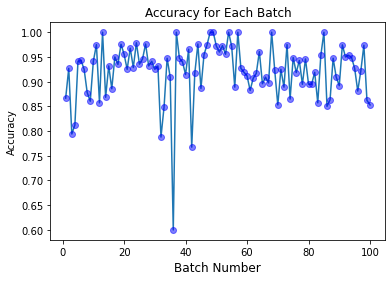

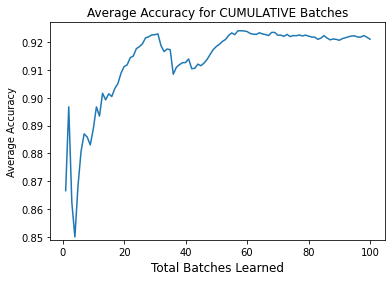

In [47]:
graph1=plt
graph1.title("Accuracy for Each Batch")
graph1.xlabel("Batch Number",size=12)
graph1.ylabel('Accuracy')
#graph1.plot(range(1,101),all_accuracies_list,)
graph1.plot(range(1,101),all_accuracies_list)
graph1.plot(range(1,101),all_accuracies_list,'bo',alpha=0.5)
graph1.show()

graph2=plt
graph2.title("Average Accuracy for CUMULATIVE Batches")
graph2.xlabel("Total Batches Learned",size=12)
graph2.ylabel('Average Accuracy')
#graph1.plot(range(1,101),all_accuracies_list,)
graph2.plot(range(1,101),avg_accuracies_list)
graph2.ylim((np.min(avg_accuracies_list)-0.001),(np.max(avg_accuracies_list)+0.003))
graph2.show()

We can see that Every batch by itself has a different accuracy, and it seems to be fluctuating. On the other hand, we can see that at the start, the average accuracy fluctuates alot, then it starts to slowly but surely grow, at around 33 batches learned it peaks then it goes down again... After about 60 batches learned, the average accuracy kinds of stabilizes. It seems to converge. We do see an improvement as we use more and more batches. and then it stabilizes.


we actually DO see an improvement as we use more and more batches.